In [1]:
from fastai.vision.all import *
path=untar_data(URLs.CIFAR)
import torchvision.transforms as tt
aug_tfms=tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                           tt.RandomHorizontalFlip()])
class MAIRTransform(DisplayedTransform):
    split_idx,order=0,2
    def encodes(self, img: PILImage):
        return aug_tfms(img)
item_tfms = [MAIRTransform()]
clean_cifar = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items = partial(get_image_files,folders=['train','test']),
                    splitter  = FuncSplitter(lambda s: Path(s).parent.parent.name == 'test'),                    
                    get_y=parent_label,
                    item_tfms=item_tfms,
#                     batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                    )
clean_dls = clean_cifar.dataloaders(path,bs=800)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_model_():
    net = models.resnet18(pretrained=True)
    num_ftrs = net.fc.in_features  
    # 将全连接层的输出维度改为2，因为我们这里要做2分类  
    net.fc = nn.Linear(num_ftrs, 10)    
    return torch.nn.DataParallel(net)
epochs=100

In [3]:
!pip install torchattacks > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.

apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.

beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.

conda 23.7.3 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is incompatible.

docker 6.1.3 requires requests>=2.26.0, but you have requests 2.25.1 which is incompatible.

gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.9.0 which is incompatible.

google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.

google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14

In [4]:
import torchattacks,tqdm
from skimage import img_as_ubyte,img_as_float
def TC(data):return data.as_subclass(torch.Tensor)
accs=[]

In [5]:
model=get_model_()
atk=None
def att_cb(cb, xb, yb):
    global atk
    if atk is None:
        atk=torchattacks.PGD(attack_learn.model)
    with torch.enable_grad():
        imgs=atk(TC(*xb),TC(*yb))
#     for (x, y) in np.ndindex(imgs.shape[:2]):
#         img=Image.fromarray(img_as_ubyte(imgs[x,y].cpu().numpy()))
#         imgs[x,y]=torch.from_numpy(img_as_float(img.convert("1")))
    return (imgs,),yb

attack_learn = Learner(clean_dls,  model, metrics=accuracy, cbs=[before_batch_cb(att_cb)])
attack_learn.fit(epochs, cbs=[SaveModelCallback()])
preds=attack_learn.get_preds(dl=clean_dls.valid)
print("半调防御样本识别率：", accuracy(*preds))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.093748,2.070084,0.235400,01:35
1,2.028010,1.937955,0.261700,01:39
2,1.956259,1.877087,0.302200,01:39
3,1.901832,1.821494,0.327500,01:39
4,1.859036,1.793244,0.329500,01:39
5,1.821750,1.764469,0.345900,01:39
6,1.792394,1.738837,0.347300,01:39
7,1.773184,1.747178,0.344900,01:39
8,1.751421,1.717371,0.354300,01:39
9,1.729059,1.699780,0.355100,01:39


Better model found at epoch 0 with valid_loss value: 2.0700840950012207.

Better model found at epoch 1 with valid_loss value: 1.9379554986953735.

Better model found at epoch 2 with valid_loss value: 1.877087116241455.

Better model found at epoch 3 with valid_loss value: 1.8214935064315796.

Better model found at epoch 4 with valid_loss value: 1.7932440042495728.

Better model found at epoch 5 with valid_loss value: 1.7644685506820679.

Better model found at epoch 6 with valid_loss value: 1.7388373613357544.

Better model found at epoch 8 with valid_loss value: 1.7173705101013184.

Better model found at epoch 9 with valid_loss value: 1.6997795104980469.

Better model found at epoch 10 with valid_loss value: 1.6914578676223755.

Better model found at epoch 11 with valid_loss value: 1.6731008291244507.

Better model found at epoch 14 with valid_loss value: 1.672165870666504.

Better model found at epoch 15 with valid_loss value: 1.66939377784729.

Better model found at epoch 16 with va

半调防御样本识别率： TensorBase(0.3838)


In [6]:
ls -al models

total 43760

drwxr-xr-x 2 root root     4096 Mar  6 16:23 ./

drwxr-xr-x 3 root root     4096 Mar  6 16:23 ../

-rw-r--r-- 1 root root 44798229 Mar  6 16:53 model.pth


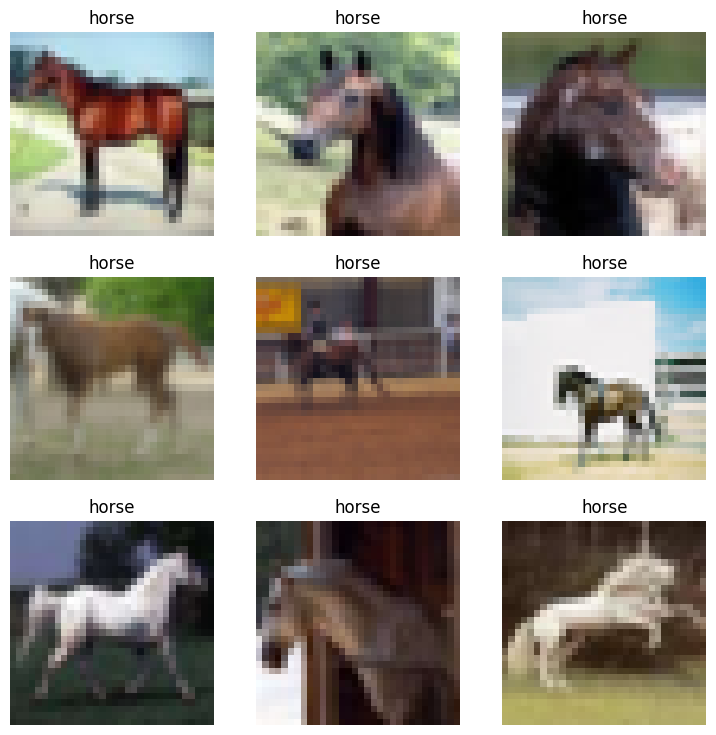

In [7]:
clean_dls.valid.show_batch()

In [8]:
accs=[]
model.eval()
for b in tqdm.tqdm(clean_dls.valid):
    preds=model(b[0])
    accs.append(accuracy(preds,b[1]).cpu().numpy())
print("干净样本识别率：", np.mean(accs))

100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

干净样本识别率： 0.62740386


In [9]:
accs=[]
for b in tqdm.tqdm(clean_dls.valid):
    imgs=atk(TC(b[0]),TC(b[1]))
    preds=model(imgs)
    accs.append(accuracy(preds,b[1]).cpu().numpy())
print("对抗样本识别率：", np.mean(accs))

100%|██████████| 13/13 [00:16<00:00,  1.27s/it]

对抗样本识别率： 0.37038457


In [10]:
accs=[]
for b in tqdm.tqdm(clean_dls.valid):
    imgs=atk(TC(b[0]),TC(b[1]))
    for (x, y) in np.ndindex(imgs.shape[:2]):
        img=Image.fromarray(img_as_ubyte(imgs[x,y].cpu().numpy()))
        imgs[x,y]=torch.from_numpy(img_as_float(img.convert("1")))    
    preds=model(imgs)
    accs.append(accuracy(preds,b[1]).cpu().numpy())
print("半调对抗样本识别率：", np.mean(accs))

100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

半调对抗样本识别率： 0.35769227


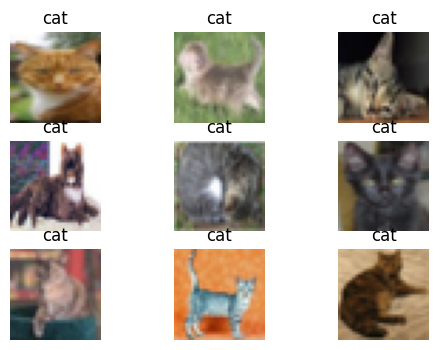

In [11]:
clean_dls.valid.show_batch(b,figsize=(6,4))

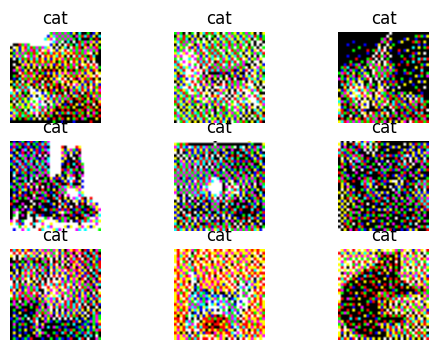

In [12]:
clean_dls.valid.show_batch([imgs,b[1]],figsize=(6,4))